
## Generative Adversarial Networks (GANs)

### Introduction

Generative Adversarial Networks (GANs) are a class of machine learning models first introduced by Ian Goodfellow and his colleagues in 2014. They consist of two neural networks – a generator and a discriminator – that compete against each other. These networks can be used to generate realistic data that resemble the training dataset. [1]

### How GANs Work

#### Basic Principle
A GAN consists of two competing networks:

- **Generator (G)**: Creates new data instances that resemble the training data.
- **Discriminator (D)**: Evaluates whether the data is real or generated by the generator.

The goal of the generator is to deceive the discriminator by producing data that appears as realistic as possible. The discriminator, on the other hand, tries to distinguish real data from fake data. This is described as a minimax game, where both networks are continuously improving to better perform their respective tasks.

#### Mathematical Formulation
The loss function of a GAN is described by the following equation [1]:

$$ \min_G \max_D V(D,G) = E_{x \sim p_{data}(x)} [ \log D(x) ] + E_{z \sim p_z(z)} [ \log (1 - D(G(z))) ] $$

### Why Use Fréchet Inception Distance (FID) in My Code

The Fréchet Inception Distance (FID) is a metric commonly used to evaluate the quality of generated data. The FID score compares the distribution of the real data with the distribution of the generated data. A lower FID score indicates that the generated data is more similar to the real data. [2]

#### Calculation of FID

The FID calculates the difference in the means and covariances between the real and generated data distributions. This difference is quantified using the following formula [2]:

$$
\text{FID} = \| \mu_r - \mu_g \|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}) 
$$

where $\mu_r$ and $\Sigma_r$ are the mean and covariance matrix of the real data, and $\mu_g$ and $\Sigma_g$ are the corresponding parameters of the generated data. The FID is often calculated using features extracted from a pre-trained Inception network, which enhances the robustness and reliability of the evaluation.

#### Importance of FID

The use of FID is important because it goes beyond merely evaluating the discriminator's performance. While the discriminator only differentiates between real and generated data, the FID assesses the actual similarity of the distributions. This allows for a more comprehensive and meaningful evaluation of the quality of the generated data. [2]

### Model Training

The model was trained over 500 epochs, using the FID as a metric to evaluate performance.


### GAN Training Analysis

#### Filtered FID Score over Epochs

The graph shows that the FID score quickly drops from a very high value to below 100 and then remains relatively stable. This indicates that the generator improved rapidly and then remained at a consistent level. This is a good sign, indicating that the GAN can produce high-quality images. [2]

![Filtered FID Score](images/filtered_fid_scores.png)

#### Generator and Discriminator Loss over Epochs

- This graph shows the loss of the generator and discriminator over the training period.
- The discriminator loss (blue line) is relatively constant, fluctuating slightly around 1. This shows that the discriminator is working consistently and has difficulty distinguishing real from fake images, which is normal in a balanced GAN.
- The generator loss (orange line) drops quickly at the beginning and then stabilizes at a low level. A low generator loss is desirable as it indicates that the generator can produce images that the discriminator finds hard to distinguish.

![Generator and Discriminator Loss](images/gan_losses.png)

#### Generated Image at 500 Epochs

The image below shows the generated image from the GAN at epoch 500.

![Generated Image at 500](images/generated_images_epoch500.png)

#### Summary

- **Good Results**: The FID score shows rapid improvement and remains at a low level, indicating good image quality.
- **Stable Losses**: Both losses are stable, indicating balanced training. The discriminator is not learning too fast or too slow compared to the generator.

Overall, these results show that the GAN can generate high-quality images. There are no signs of significant issues such as mode collapse or overfitting.

#### Sources

[1] J. Gui, Z. Sun, Y. Wen, D. Tao and J. Ye, "A Review on Generative Adversarial Networks: Algorithms, Theory, and Applications," in IEEE Transactions on Knowledge and Data Engineering, vol. 35, no. 4, pp. 3313-3332, 1 April 2023, doi: 10.1109/TKDE.2021.3130191. URL: https://ieeexplore.ieee.org/abstract/document/9625798?casa_token=74ktz8Hg_jMAAAAA:Zoqv-XGMM2ly9AQ82I1G9gDKCivEyzB_LIccyX8rhRCctl5WMbPSBAS2zo8TueoOTh286vNwF4Q

[2] Yu, Yu, Weibin Zhang, and Yun Deng. "Frechet inception distance (fid) for evaluating gans." China University of Mining Technology Beijing Graduate School 3 (2021). URL: https://www.researchgate.net/profile/Yu-Yu-120/publication/354269184_Frechet_Inception_Distance_FID_for_Evaluating_GANs/links/612f01912b40ec7d8bd87953/Frechet-Inception-Distance-FID-for-Evaluating-GANs.pdf

### Add Imports

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
from scipy.linalg import sqrtm
import numpy as np
from torchvision.models import inception_v3


### Define Hyperparameters

In [2]:

os.makedirs("images", exist_ok=True)
os.makedirs("models", exist_ok=True)

#define Hyperparameter


latent_dim = 100  
batch_size = 128  
epochs = 500 
lr = 0.0002  
beta1 = 0.5  
start_epoch = 0  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True) # MNIST-Datensatz laden
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)   # Dataloader erstellen


### Create Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),  # Input layer: 784 (28x28 pixels)
            nn.LeakyReLU(0.2),  # LeakyReLU activation
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, 256),  # Hidden layer
            nn.LeakyReLU(0.2),  # LeakyReLU activation
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(256, 1),  # Output layer
            nn.Sigmoid()  # Sigmoid activation to output a probability
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)  # Reshape the input image
        return self.model(x)  # Pass the reshaped input through the model


### Create Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),  # Input layer: latent space
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(256, 512),  # Hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, 1024),  # Hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(1024, 784),  # Output layer
            nn.Tanh()  # Tanh activation to output pixel values in the range [-1, 1]
        )

    def forward(self, x):
        return self.model(x).view(x.size(0), 1, 28, 28)  # Reshape to image format


### Create VAE

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)  
        self.fc21 = nn.Linear(400, 20)  
        self.fc22 = nn.Linear(400, 20) 
        self.fc3 = nn.Linear(20, 400)  
        self.fc4 = nn.Linear(400, 784) 

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) 

    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5 * logvar) 
        eps = torch.randn_like(std) 
        return mu + eps * std 

    def decode(self, z):   
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784)) 
        z = self.reparameterize(mu, logvar) 
        return self.decode(z), mu, logvar 


### Load checkpoints and epochs

In [6]:
vae = VAE().to(device)

econstruction_loss = nn.BCELoss(reduction='sum') 
optimizerVAE = optim.Adam(vae.parameters(), lr=1e-3)  

D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()  
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999)) 
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))  

def load_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    start_epoch = 0
    if os.path.isfile(filename):
        print(f"=> Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        print(f"=> No checkpoint found at '{filename}'")
    return start_epoch

start_epoch_G = load_checkpoint(G, optimizerG, 'models/G_checkpoint.pth.tar')
start_epoch_D = load_checkpoint(D, optimizerD, 'models/D_checkpoint.pth.tar')
start_epoch_VAE = load_checkpoint(vae, optimizerVAE, 'models/VAE_checkpoint.pth.tar')
start_epoch = max(start_epoch_G, start_epoch_D, start_epoch_VAE)

=> Loading checkpoint 'models/G_checkpoint.pth.tar'
=> Loaded checkpoint 'models/G_checkpoint.pth.tar' (epoch 500)
=> Loading checkpoint 'models/D_checkpoint.pth.tar'
=> Loaded checkpoint 'models/D_checkpoint.pth.tar' (epoch 500)
=> Loading checkpoint 'models/VAE_checkpoint.pth.tar'
=> Loaded checkpoint 'models/VAE_checkpoint.pth.tar' (epoch 500)


### Train VAE 

In [7]:
def train_vae(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizerVAE.zero_grad() 
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item() 
        optimizerVAE.step() 
        if batch_idx % 100 == 0: 
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(data_loader.dataset)} ({100. * batch_idx / len(data_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}') 
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(data_loader.dataset):.4f}')

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_loss(recon_x, x.view(-1, 784))  
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  
    return BCE + KLD

### Create FID

In [8]:
def calculate_fid(model, real_images, fake_images):
    
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Change images to size 299x299 (input size for Inception) and expand to 3 channels

    real_images_resized = F.interpolate(real_images.expand(-1, 3, -1, -1), size=(299, 299), mode='bilinear', align_corners=False)
    fake_images_resized = F.interpolate(fake_images.expand(-1, 3, -1, -1), size=(299, 299), mode='bilinear', align_corners=False)

   
    real_features = inception(real_images_resized).detach().cpu().numpy()
    fake_features = inception(fake_images_resized).detach().cpu().numpy()

  
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

  
    ssdiff = np.sum((mu_real - mu_fake)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean): 
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean) 
    return fid


### Get recent values of already calculated epochs for fid score, d and g loss

In [9]:
# Initialize lists to store values
fid_scores = []
d_losses = []
g_losses = []

# Check if the files exist and read the existing data if present
if os.path.exists('logs/fid_values.txt') and os.path.getsize('logs/fid_values.txt') > 0:
    with open('logs/fid_values.txt', 'r') as fid_file:
        fid_values = [(line.strip()) for line in fid_file]

if os.path.exists('logs/loss_values.txt') and os.path.getsize('logs/loss_values.txt') > 0:
    with open('logs/loss_values.txt', 'r') as loss_file:
        loss_values = [tuple(map(float, line.strip().split(','))) for line in loss_file]

for epoch, (fid, (d_loss, g_loss)) in enumerate(zip(fid_values, loss_values), start=1):
    print(f"Epoch {epoch}: FID = {fid}, d_loss = {d_loss}, g_loss = {g_loss}")
    fid_scores.append(fid)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

Epoch 1: FID = -3.4253944624943037e+46, d_loss = 0.7934081554412842, g_loss = 2.2834959030151367
Epoch 2: FID = -1.2544169174173476e+43, d_loss = 0.6781949996948242, g_loss = 2.2721524238586426
Epoch 3: FID = -2.8499281927952607e+49, d_loss = 0.36442482471466064, g_loss = 6.109364986419678
Epoch 4: FID = 611.4889526367188, d_loss = 0.29416221380233765, g_loss = 3.2397372722625732
Epoch 5: FID = -2.5521177519070385e+38, d_loss = 0.28604599833488464, g_loss = 3.2488410472869873
Epoch 6: FID = -7.975367974709495e+36, d_loss = 0.49203240871429443, g_loss = 3.159815549850464
Epoch 7: FID = -2.9076862407795035e+35, d_loss = 0.5744279623031616, g_loss = 2.2750706672668457
Epoch 8: FID = -1.2259964326927111e+55, d_loss = 0.6327621340751648, g_loss = 2.1774535179138184
Epoch 9: FID = 5.5169839471172e+55, d_loss = 0.9289235472679138, g_loss = 1.8606107234954834
Epoch 10: FID = 3.9876839873547476e+37, d_loss = 0.9359865188598633, g_loss = 1.044119119644165
Epoch 11: FID = 1.7014118346046923e+38, 

### Training Loop

In [10]:


for epoch in range(start_epoch, epochs):
    for i, (imgs, _) in enumerate(data_loader):
        real_imgs = imgs.to(device)
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z)

       
        optimizerD.zero_grad()
        outputs = D(real_imgs)
        d_loss_real = criterion(outputs, real_labels)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        
        optimizerG.zero_grad()
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()

    if (epoch + 1) == 1:
        images = real_imgs.reshape(real_imgs.size(0), 1, 28, 28)
        save_image(images, './images/real_images.png')

    fake_images = fake_imgs.reshape(fake_imgs.size(0), 1, 28, 28)
    save_image(fake_images, f'./images/fake_images-{epoch + 1}.png')


    # FID calculation
    fid = calculate_fid(inception_v3, real_imgs, fake_imgs)
    fid_scores.append(fid)
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
    print(f'FID after epoch {epoch + 1}: {fid:.4f}')


    # Append new FID and loss values to files
    with open('logs/fid_values.txt', 'a') as fid_file:
        fid_file.write(f"{fid}\n")

    with open('logs/loss_values.txt', 'a') as loss_file:
        loss_file.write(f"{d_loss.item()},{g_loss.item()}\n")


    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(), f'models/G_epoch{epoch + 1}.pth')
        torch.save(D.state_dict(), f'models/D_epoch{epoch + 1}.pth')
        torch.save(vae.state_dict(), f'models/VAE_epoch{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': G.state_dict(),
            'optimizer': optimizerG.state_dict(),
        }, 'models/G_checkpoint.pth.tar')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': D.state_dict(),
            'optimizer': optimizerD.state_dict(),
        }, 'models/D_checkpoint.pth.tar')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': vae.state_dict(),
            'optimizer': optimizerVAE.state_dict(),
        }, 'models/VAE_checkpoint.pth.tar')

torch.save(G.state_dict(), 'models/G_final.pth')
torch.save(D.state_dict(), 'models/D_final.pth')
torch.save(vae.state_dict(), 'models/VAE_final.pth')


#### Visualize results

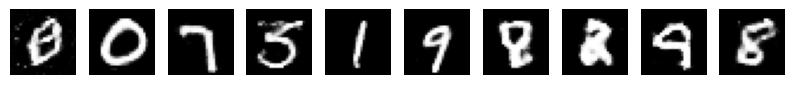

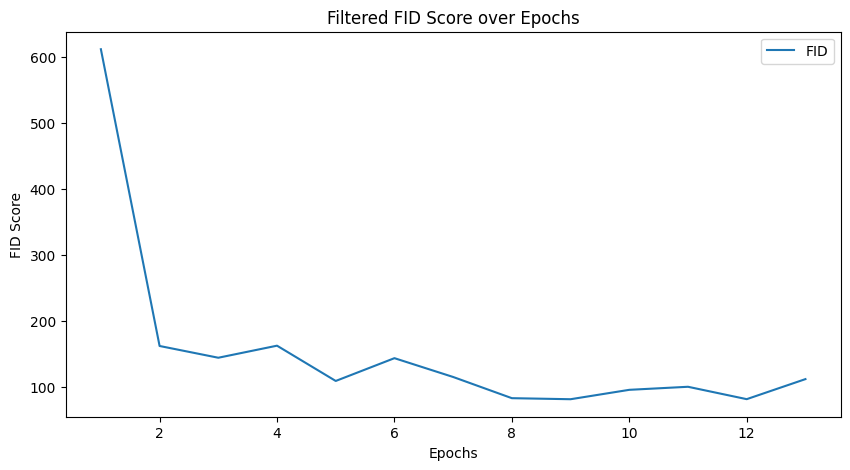

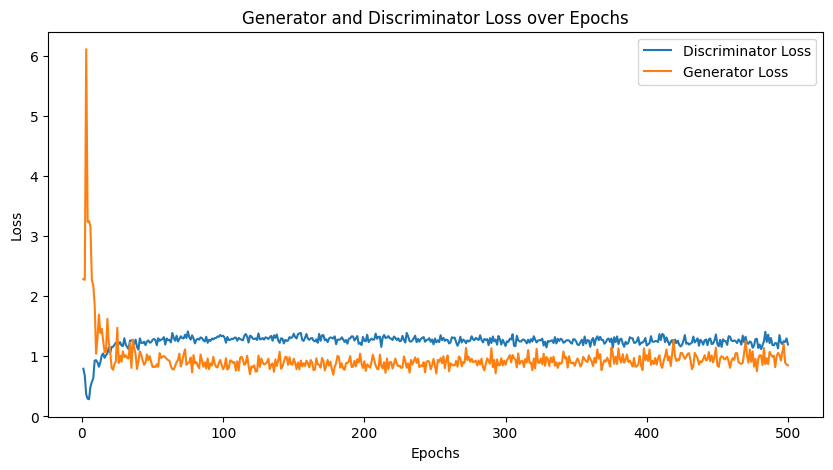

In [11]:
# Convert all values to floats and filter out any that can't be converted
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return None

# Apply the conversion and filter out extreme values
filtered_fid_values = [value for value in map(convert_to_float, fid_scores) if value is not None and -1e6 < value < 1e6]
def plot_generated_images(epoch, examples=10):
    z = torch.randn(examples, latent_dim).to(device)
    G.eval()
    with torch.no_grad():
        generated_images = G(z)
    generated_images = generated_images.cpu().detach()
    plt.figure(figsize=(10, 10))
    for i in range(examples):
        plt.subplot(1, examples, i+1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.savefig(f'./images/generated_images_epoch{epoch}.png')
    plt.show()

# Plot images for final epoch
plot_generated_images(epochs)


# Plot the cleaned FID scores over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(filtered_fid_values) + 1), filtered_fid_values, label='FID')
plt.xlabel('Epochs')
plt.ylabel('FID Score')
plt.legend()
plt.title('Filtered FID Score over Epochs')
plt.savefig('./images/filtered_fid_scores.png')
plt.show()

# Plot Generator and Discriminator Loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_losses) + 1), d_losses, label='Discriminator Loss')
plt.plot(range(1, len(g_losses) + 1), g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss over Epochs')
plt.savefig('./images/gan_losses.png')
plt.show()
